<a href="https://www.kaggle.com/code/sjagkoo7/s3e9-regression-of-used-car-prices?scriptVersionId=196672503" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# About Dataset & Model
The goal is to predict the price of used cars based on various attributes. As per data target variable is a continuous value.Hence, it falls uunder supervised learning - regression problems.

# Import Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import polars as pl # data processing
import matplotlib.pyplot as plt # visualization
import seaborn as sns # convient to use
import plotly.express as px #create basic visualizations
import plotly.graph_objects as go #complex chart


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e9/sample_submission.csv
/kaggle/input/playground-series-s4e9/train.csv
/kaggle/input/playground-series-s4e9/test.csv


# Reading the dataset

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')

In [3]:
train.head(2)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999


In [4]:
test.head(2)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes


In [5]:
submission.head(2)

,id,price
0,188533,43878.016
1,188534,43878.016


# Data Pre-Processing
## Dataset Summary

In [6]:
#Dataset Summary
def summary(train):
    df = pd.DataFrame(index = train.columns)
    df['dtypes'] = train.dtypes
    df['count'] = train.count()
    df['#unique'] = train.nunique()
    df['null'] = train.isna().sum()
    df['missing%']=train.isna().sum()/len(train)*100
    df = pd.concat([df,train.describe().T.drop('count',axis =1)],axis=1)
    return df

In [7]:
# Summary of Train Dataset
summary(train).style.background_gradient(cmap = 'YlGnBu')

,dtypes,count,#unique,null,missing%,mean,std,min,25%,50%,75%,max
id,int64,188533,188533,0,0.000000,94266.000000,54424.933488,0.000000,47133.000000,94266.000000,141399.000000,188532.000000
brand,object,188533,57,0,0.000000,nan,nan,nan,nan,nan,nan,nan
model,object,188533,1897,0,0.000000,nan,nan,nan,nan,nan,nan,nan
model_year,int64,188533,34,0,0.000000,2015.829998,5.660967,1974.000000,2013.000000,2017.000000,2020.000000,2024.000000
milage,int64,188533,6651,0,0.000000,65705.295174,49798.158076,100.000000,24115.000000,57785.000000,95400.000000,405000.000000
fuel_type,object,183450,7,5083,2.696080,nan,nan,nan,nan,nan,nan,nan
engine,object,188533,1117,0,0.000000,nan,nan,nan,nan,nan,nan,nan
transmission,object,188533,52,0,0.000000,nan,nan,nan,nan,nan,nan,nan
ext_col,object,188533,319,0,0.000000,nan,nan,nan,nan,nan,nan,nan
int_col,object,188533,156,0,0.000000,nan,nan,nan,nan,nan,nan,nan


In [8]:
# Summary of Test Dataset
summary(test).style.background_gradient(cmap = 'PuBuGn')

,dtypes,count,#unique,null,missing%,mean,std,min,25%,50%,75%,max
id,int64,125690,125690,0,0.000000,251377.500000,36283.722005,188533.000000,219955.250000,251377.500000,282799.750000,314222.000000
brand,object,125690,55,0,0.000000,nan,nan,nan,nan,nan,nan,nan
model,object,125690,1891,0,0.000000,nan,nan,nan,nan,nan,nan,nan
model_year,int64,125690,36,0,0.000000,2015.797526,5.673797,1974.000000,2013.000000,2017.000000,2020.000000,2024.000000
milage,int64,125690,5700,0,0.000000,66042.581510,50223.858435,100.000000,24500.000000,57500.000000,95798.000000,405000.000000
fuel_type,object,122307,7,3383,2.691543,nan,nan,nan,nan,nan,nan,nan
engine,object,125690,1117,0,0.000000,nan,nan,nan,nan,nan,nan,nan
transmission,object,125690,52,0,0.000000,nan,nan,nan,nan,nan,nan,nan
ext_col,object,125690,317,0,0.000000,nan,nan,nan,nan,nan,nan,nan
int_col,object,125690,156,0,0.000000,nan,nan,nan,nan,nan,nan,nan


> clean_title is having only value either it is null, hence dropping the feature.

In [9]:
# dropping clean_title from train and test dataset
train.drop('clean_title',axis=1, inplace = True)
test.drop('clean_title',axis=1, inplace = True)

## Handling Null Values

In [10]:
train[train.isna().any(axis=1)][:2]

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price
11,11,Tesla,Model S P100D,2015,81500,NaN,Electric Motor Electric Fuel System,1-Speed A/T,Gray,White,None reported,19000
32,32,Tesla,Model S P100D,2018,30300,NaN,518.0HP Electric Motor Electric Fuel System,A/T,White,White,None reported,64000


> **Observations:** 
- fuel_type - 2.69% , accident - 1.30% have missing values.
- Dropping all the values missing values.

In [11]:
# dropping all the null rows
train.dropna(inplace = True)

In [12]:
summary(train).style.background_gradient(cmap = 'YlGnBu')

,dtypes,count,#unique,null,missing%,mean,std,min,25%,50%,75%,max
id,int64,181067,181067,0,0.000000,94240.503659,54429.282684,0.000000,47111.500000,94240.000000,141377.500000,188532.000000
brand,object,181067,57,0,0.000000,nan,nan,nan,nan,nan,nan,nan
model,object,181067,1888,0,0.000000,nan,nan,nan,nan,nan,nan,nan
model_year,int64,181067,34,0,0.000000,2015.688215,5.672103,1974.000000,2013.000000,2017.000000,2020.000000,2024.000000
milage,int64,181067,6480,0,0.000000,66894.919996,49905.983232,100.000000,25000.000000,59400.000000,96476.000000,405000.000000
fuel_type,object,181067,7,0,0.000000,nan,nan,nan,nan,nan,nan,nan
engine,object,181067,1108,0,0.000000,nan,nan,nan,nan,nan,nan,nan
transmission,object,181067,52,0,0.000000,nan,nan,nan,nan,nan,nan,nan
ext_col,object,181067,319,0,0.000000,nan,nan,nan,nan,nan,nan,nan
int_col,object,181067,156,0,0.000000,nan,nan,nan,nan,nan,nan,nan


In [13]:
cols = list(train.columns)
obj_cols = [col for col in cols if train[col].dtype == 'O']
# for col in cols:
#     if train[col].dtype == 'O':
#         obj_cols.append(col)

# model_year can be also treated as obj type
obj_cols.append('model_year')  
obj_cols

['brand',
 'model',
 'fuel_type',
 'engine',
 'transmission',
 'ext_col',
 'int_col',
 'accident',
 'model_year']

## Data Analysis

In [14]:
#Find the top 5 most popular brands and their average prices, while also displaying the count of each brand.
df1 = train[['brand','price']]
avg=df1.groupby(by='brand').mean()
avg['count']= df1.groupby(by='brand').size()
avg = avg.sort_values(by='count',ascending=False)[0:5]
avg

# top_brands = train.groupby('brand')['price'].agg(['mean', 'count']).sort_values('count', ascending=False).head(5)
# print(top_brands)

,price,count
brand,,
Ford,39981.806641,22347
Mercedes-Benz,51065.490921,18944
BMW,43598.415598,16771
Chevrolet,41684.053283,16084
Audi,40869.569313,10669


In [15]:
#Analyze the relationship between engine size and fuel type, and determine the average price for each combination
train.pivot_table(values='price',index='engine',columns='fuel_type',aggfunc="mean")
# values - it indicate the on which column we want to apply aggreagte function
# index - rows

fuel_type,Diesel,E85 Flex Fuel,Gasoline,Hybrid,Plug-In Hybrid,not supported,–
engine,,,,,,,
1.2L I3 12V GDI DOHC Turbo,NaN,NaN,35515.541667,NaN,NaN,NaN,NaN
1.3L I3 12V GDI DOHC Turbo,NaN,NaN,34915.172414,NaN,NaN,NaN,NaN
1.3L I3 12V MPFI DOHC Turbo,NaN,NaN,31052.375000,NaN,NaN,NaN,NaN
1.4L I4 16V GDI DOHC Turbo,NaN,NaN,24459.636364,NaN,NaN,NaN,NaN
1.5 Liter Turbo,NaN,NaN,37198.166667,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
Intercooled Turbo Premium Unleaded I-4 2.0 L/122,NaN,NaN,48584.435897,NaN,NaN,NaN,NaN
Standard Range Battery,48998.0,NaN,49134.333333,40888.000000,NaN,NaN,NaN
V6,NaN,NaN,55535.769231,57774.666667,NaN,NaN,NaN


In [16]:
#Find the 3 most common exterior and interior colors, and calculate the average price for each color combination
train.groupby(['ext_col','int_col'])['price'].agg('mean').head(3)

ext_col               int_col    
Agate Black Metallic  Agave Green    32063.000000
                      Black          58749.875984
                      Black Onyx     50597.000000
Name: price, dtype: float64

## Data Visulization

In [17]:
#How does the mileage impact the price of cars across different brands and fuel types of top 5 brand car?
top5_brand = list(avg.index)
data = train[train['brand'].isin(top5_brand)]

In [18]:
class MilagePricePlotter:
    
    def __init__(self,data):
        self.data = data
        self.fig = None
        self.g = None
        
    def create_plot(self,row = 'fuel_type',col = 'brand',x='milage',y='price' ):
        # Set the style and figure size
        plt.figure(figsize=(32, 12))
        # Create the FacetGrid
        self.g = sns.FacetGrid(data , row = row,col = col,aspect=1.5)
        # Map the scatter plot
        self.g.map_dataframe(sns.scatterplot,x=x,y=y)
        return self
    
    def set_labels_and_titles(self,x_label='Mileage', y_label='Price',title='Mileage vs Price Across Brands and Fuel Types'):
        # Set labels and titles
        self.g.set_axis_labels(x_var = x_label,y_var = y_label)
        self.g.set_titles(row_template="{row_name}", col_template="{col_name}")
        # Adjust the layout
        self.g.fig.subplots_adjust(top=0.92, hspace=0.3)
        # Add a title
        self.g.fig.suptitle(title, fontsize=24)
        return self
    
    def show_plot(self):
        plt.show()

<Figure size 3200x1200 with 0 Axes>

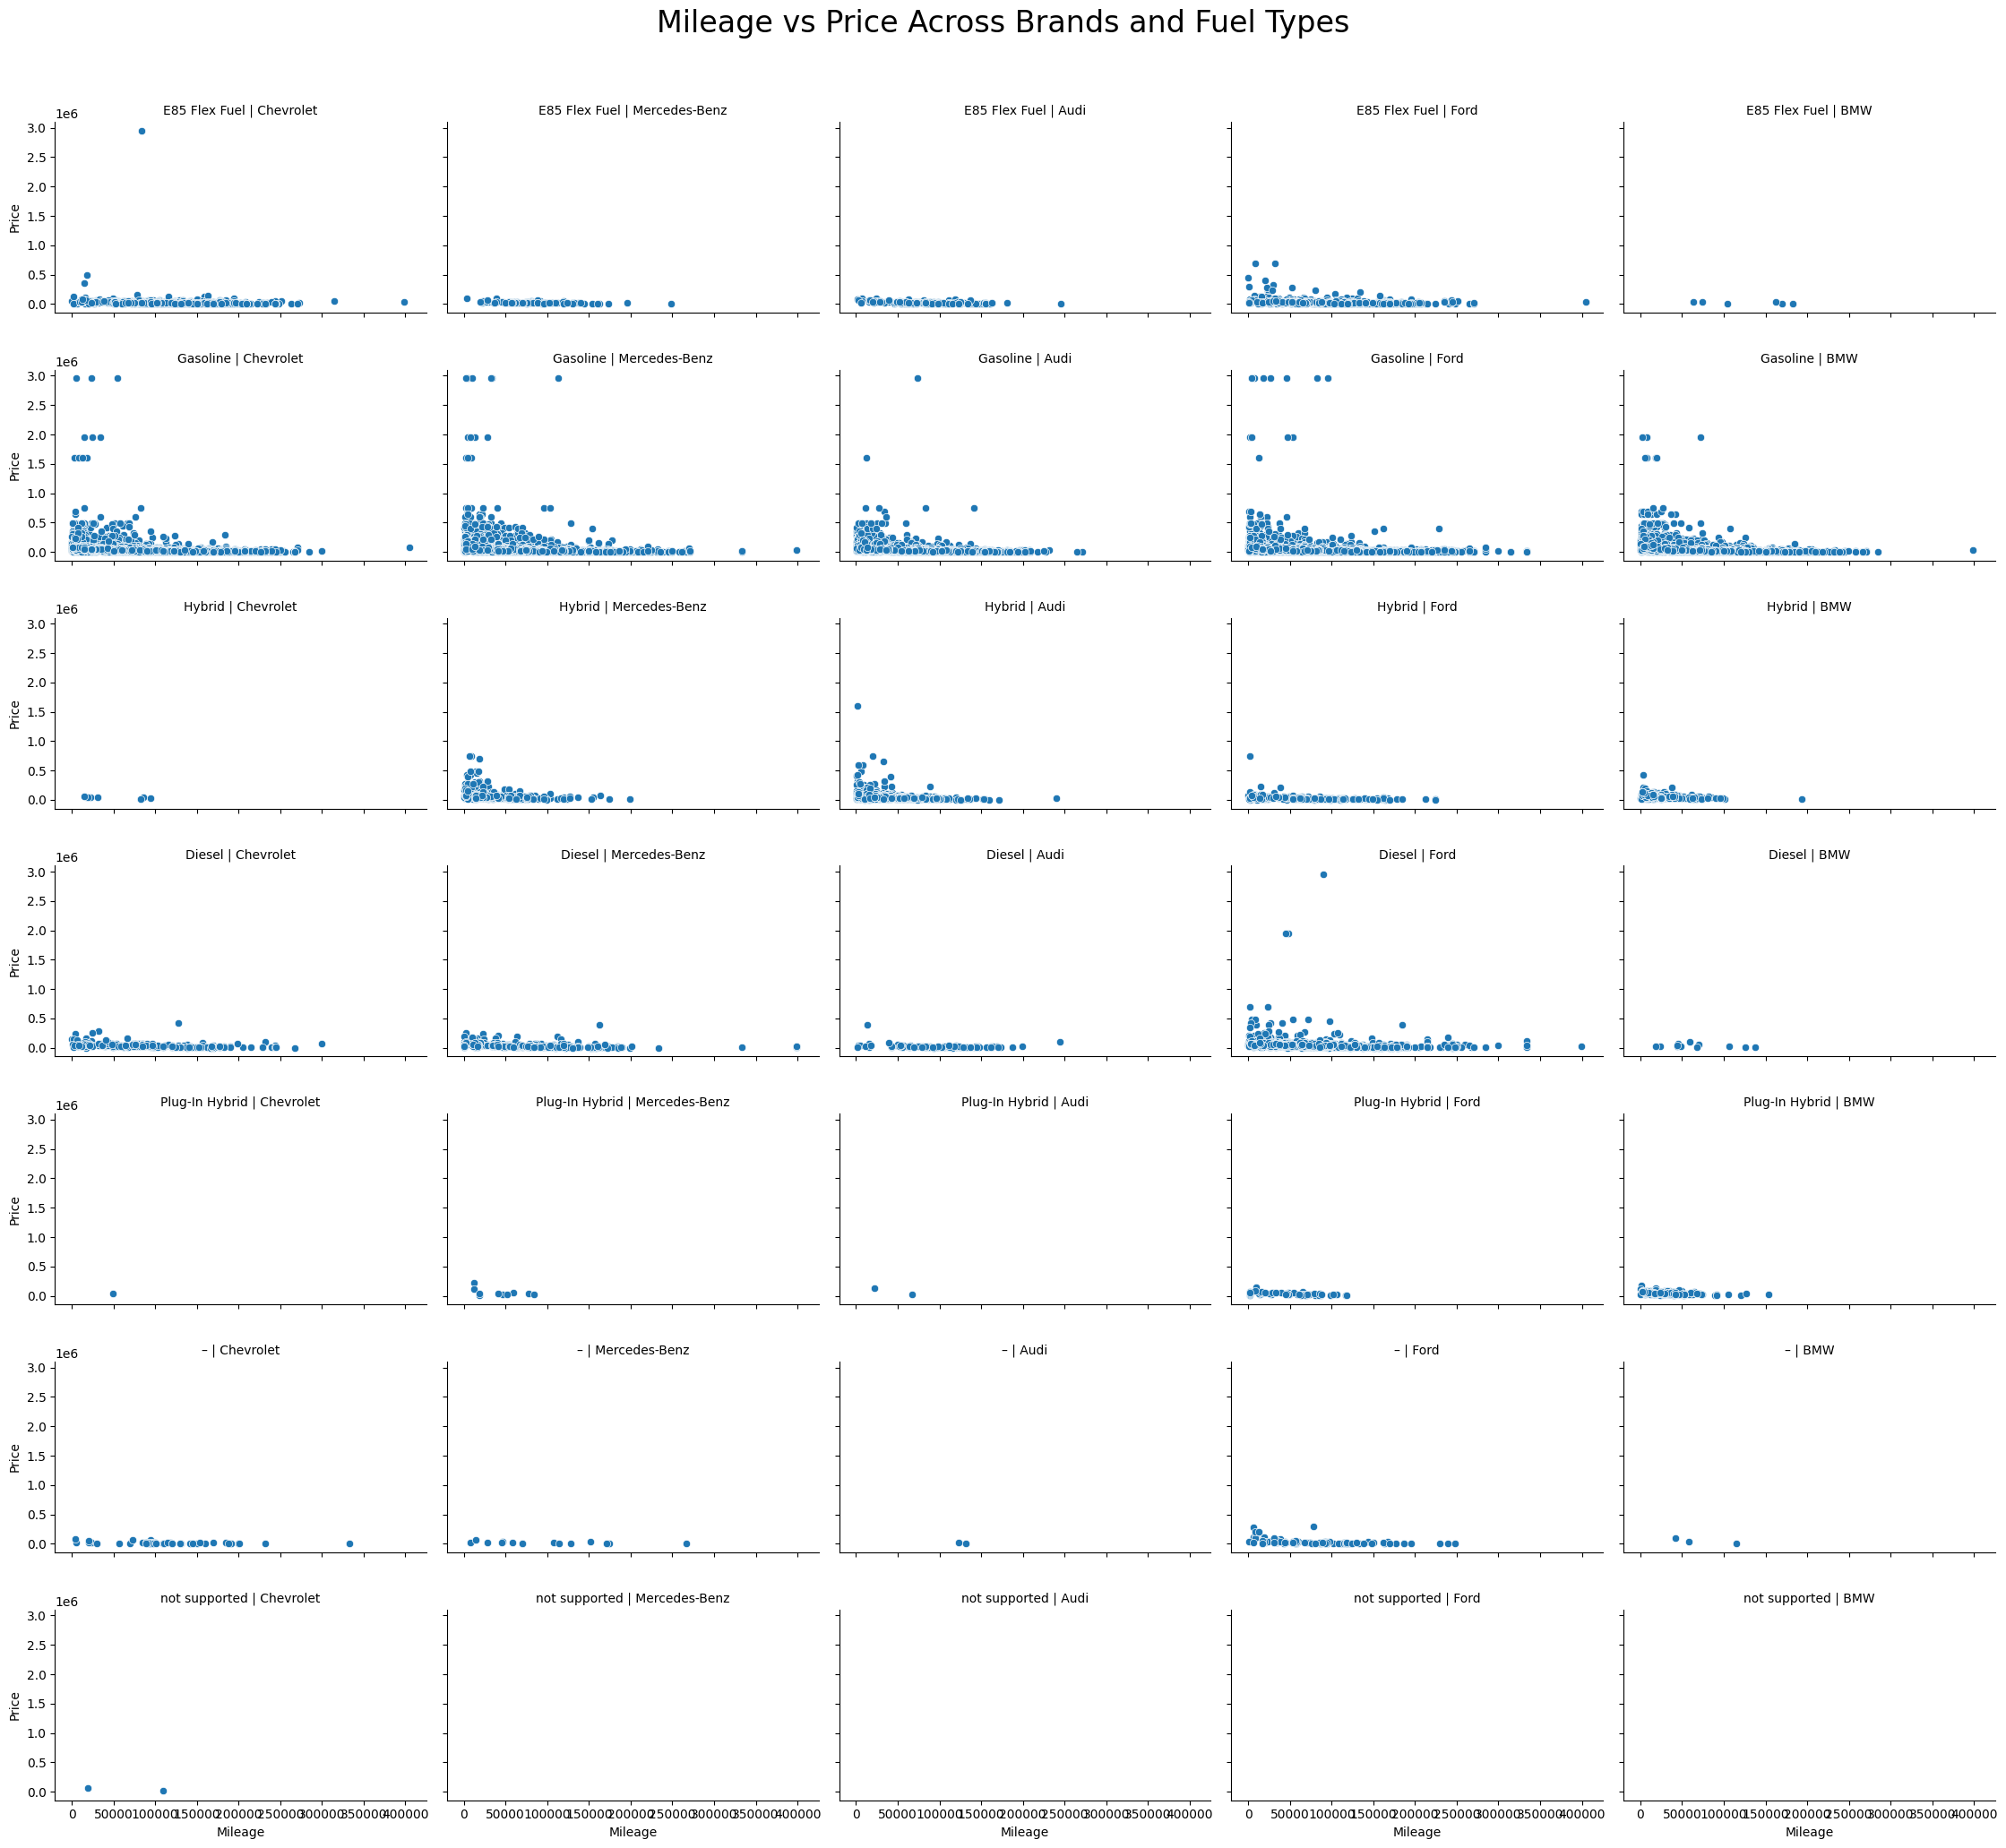

In [19]:
if __name__ == "__main__":
    plotter = MilagePricePlotter(data)
    plotter.create_plot()\
           .set_labels_and_titles() \
           .show_plot()

In [20]:
#How do different engine sizes and transmission types affect car prices across various model years?
#What is the correlation between exterior color (ext_col), accident history (accident), and price across brands?